In [10]:
import pandas as pd  
import base64
from io import BytesIO
from PIL import Image  
import numpy as np  
import openpyxl  
import jieba.posseg as pseg
import tqdm
import wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt  
import matplotlib.colors as colors
from pathlib import Path
import os
import re
from snownlp import SnowNLP
from  wordcloud import ImageColorGenerator
from imageio import imread
from IPython.display import display, HTML
from PIL import Image, ImageDraw, ImageFont

In [11]:
for i in os.listdir('./txt'):
    try:
        os.mkdir('./res/'+i.split('.')[0])
    except Exception as e:
        continue

### 定义根据一个三元组生成条形占比图的函数  

In [12]:
def generate_img(data:list):
    neutral_color=(249,149,0)
    postive_color=(44,186,41)
    negative_color=(254,77,75)
    s=sum(data)
    pos=int((data[0]/s)*100)
    neu=int((data[1]/s)*100)+pos
    # 创建一个空白的RGB图像
    img = Image.new('RGB', (100, 30))
    # 获取图像的像素访问对象
    pixels = img.load()
    # 遍历每一个像素，并设置其颜色
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            if(i<pos):
                pixels[i, j] = postive_color
            elif(i<neu):
                pixels[i, j] = neutral_color
            else:
                pixels[i,j] = negative_color
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return '<img src="data:image/png;base64,' + img_str + '">'

### 画环状图的函数  


In [13]:
def draw_circular(sizes,colors,labels):
    inner_radius = 0.5  # 内圈半径，0为饼图，大于0为环形图
    fig, ax = plt.subplots()
    ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, radius=1)
    ax.pie([100], colors=['white'], radius=inner_radius)  # 内圈，白色填充
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')
    return fig

### 生成散点图的逻辑

In [14]:

def generate_scatter(x,y,path):
    x_avg=sum(x)/len(x)
    y_avg=sum(y)/len(y)
    x.append(x_avg)
    y.append(0)
    x.append(0)
    y.append(y_avg)
    fig=plt.figure(figsize=(12, 6))  # 设置图的大小
    plt.scatter(x, y, color='#546fc6', marker='o', s=50)  # 设置散点的样式和大小
    plt.text(0.05,-max(y)/20,'非常不满意',color='red',fontsize=12,ha='center')
    plt.text(0.95,-max(y)/20,'非常满意',color='green',fontsize=12,ha='center')
    # 设置图的边界和对称轴
    plt.axhline(0, color='black', linewidth=1.5)  # 绘制 y 轴在 0 点处的线
    plt.axvline(0.5, color='black', linewidth=1.5)  # 绘制 x 轴在 0 点处的线
    x_line_p_x=[x_avg,x_avg]
    x_line_p_y=[0,max(y)+max(y)/20]
    plt.plot(x_line_p_x, x_line_p_y, linestyle='--', color='#5e75dd', linewidth=0.8)
    plt.text(x_avg,max(y)+max(y)/17,str(round(x_avg,2)),color='#5e75dd',fontsize=12,ha='center')
    y_line_p_y=[y_avg,y_avg]
    y_line_p_x=[0,1]
    plt.plot(y_line_p_x, y_line_p_y, linestyle='--', color='#5e75dd', linewidth=0.8)
    plt.text(1,y_avg,str(round(y_avg,2)),color='#5e75dd',fontsize=12,ha='center')
    plt.xlim(0, 1)  # 设置 x 轴的范围
    plt.ylim(0, max(y)+max(y)/20)  # 设置 y 轴的范围，使得 y 轴处于图的中央
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # 设置坐标轴标签
    plt.xlabel('情绪分',fontsize=12)
    plt.ylabel('条数',fontsize=12)
    plt.xticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    plt.yticks([])
    # 显示网格
    plt.grid(True)
    # 显示图形
    plt.savefig(path)

## 词汇分析

### 按照标点符号进行分句操作

In [15]:
topics=['./txt/'+i for i in os.listdir('./txt/')]

In [ ]:
all_sentence_emotions=[]
for ind in range(len(topics)):
    plt.rcParams['font.sans-serif'] = str(Path('KaiTi'))
    f=open(topics[ind],'r')
    text=''
    for i in f.readlines():
        text+=i
    chinese_pattern = re.compile(r'[\u4e00-\u9fa5\d，。？！；：、]+')
    result = chinese_pattern.findall(text)
    chinese_text = (''.join(result)).replace('？','。')
    #得到合并后的文本，按照句子分句
    sentences=chinese_text.split('。')
    sentence_emotions=[]
    for sentence in sentences:
        try:
            sentence_emotions.append(SnowNLP(sentence).sentiments)
        except Exception as e:
            continue
    labels=['正面','中性','负面']
    sizes=[0,0,0]
    for emotion in sentence_emotions:
        if(emotion>=0 and emotion<=0.33):
            sizes[2]+=1
        elif(emotion>0.33 and emotion<=0.66):
            sizes[1]+=1
        else:
            sizes[0]+=1
    colors=['#2eb82d','#ff9201','#ff4c4f']
    all_sentence_emotions.append(sentence_emotions)
    draw_circular(sizes,colors,labels).savefig('./res/'+os.listdir('./res/')[ind]+'/总体语句情感比例环状图.png')

In [ ]:
iii=0
for emotions in all_sentence_emotions:
    x=np.linspace(0,1,51).tolist()
    y=np.zeros_like(x).tolist()
    for emotion in emotions:
        ind=int(emotion//0.02)
        y[ind]+=1
    x_new=[]
    y_new=[]
    for ind in range(len(y)-2):
        if(y[ind]>=1):
            x_new.append(x[ind])
            y_new.append(y[ind])
    generate_scatter(x_new,y_new,'./res/'+os.listdir('./res/')[iii]+'/总体情感散点图')
    iii+=1

### 分词操作

In [18]:
def which_attr(attr):
    if(attr in ['n','nr','ns','nt','nz','nx']):
        return '名词'
    elif(attr in ['v','vd','vn','vshi','vyou']):
        return '动词'
    elif(attr in ['a','ad','an']):
        return '形容词'
    elif(attr in ['d']):
        return '副词'
    else:
        return '其他词性'

In [19]:
def judge_exists_word(word,lis:list):
    for ind in range(len(lis)):
        if(lis[ind]['word']==word):
            return (True,ind)  
    return (False,-1)
word_msgs=[]
for topic in topics:
    f=open(topic,'r')
    text=''
    for i in f.readlines():
        text+=i
    chinese_pattern = re.compile(r'[\u4e00-\u9fa5]+')
    result = chinese_pattern.findall(text)
    chinese_text = (''.join(result)).replace('？','。')
    word_list=pseg.lcut(chinese_text)
    word_msg=[]
    for ind in range(len(word_list)):
        if(which_attr(tuple(word_list[ind])[1])=='其他词性' or len(tuple(word_list[ind])[0])<=1):#做筛选，只获取对应的
            continue
        msg={}
        msg['word']=tuple(word_list[ind])[0]
        msg['attribute']=which_attr(tuple(word_list[ind])[1])
        msg['emotion']=SnowNLP(tuple(word_list[ind])[0]).sentiments
        judge=judge_exists_word(tuple(word_list[ind])[0],word_msg)
        if(judge[0]):
            word_msg[judge[1]]['times']+=1
        else:
            msg['times']=1
            word_msg.append(msg)
    word_msgs.append(word_msg)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.429 seconds.
Prefix dict has been built successfully.


In [20]:
for ind in range(len(word_msgs)):
    word_msgs[ind]=sorted(word_msgs[ind],key=lambda x:x['times'],reverse=True)

In [21]:
def generate_cloud(word_frequency,mask_path,save_path):#生成词云
    mask=np.array(Image.open(mask_path))
    bg_color = ImageColorGenerator(imread(mask_path), default_color=None)
    word_cloud=WordCloud(width=1600,height=800,mask=mask,background_color='white',color_func=bg_color,font_path='/home/wangxv/Downloads/font1.ttf').generate_from_frequencies(word_frequency)
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off') 
    plt.savefig(fname=save_path)

/tmp/ipykernel_5235/4033091356.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bg_color = ImageColorGenerator(imread(mask_path), default_color=None)


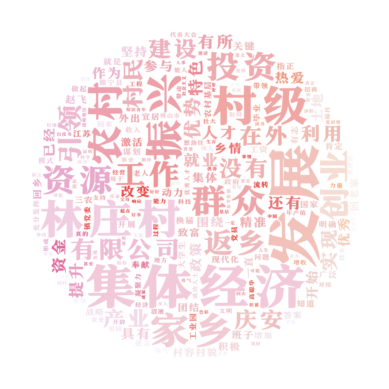

In [22]:
for ind in range(len(word_msgs)):
    positive_frequency={}
    negative_frequency={}
    for msg in word_msgs[ind]:
        if(msg['emotion']<0.2):
            negative_frequency[msg['word']]=msg['times']
        elif(msg['emotion']>0.3):
            positive_frequency[msg['word']]=msg['times']
    generate_cloud(positive_frequency,'./positive.png','./res/'+os.listdir('./res/')[ind]+'/总体正面词汇词云.png')
    #generate_cloud(negative_frequency,'./negative.png','./res/'+os.listdir('./res/')[ind]+'/总体负面词汇词云.png')
    positive_list=[{'词汇':word,'频次':frequency} for word,frequency in positive_frequency.items()]
    pd.DataFrame(positive_list).to_excel('./res/'+os.listdir('./res/')[ind]+'/总体正面词汇表.xlsx')
    #negative_list=[{'词汇':word,'频次':frequency} for word,frequency in negative_frequency.items()]
    #pd.DataFrame(negative_list).to_excel('./res/'+os.listdir('./res/')[ind]+'/总体负面词汇表.xlsx')

### 逐句分析

In [23]:
def judge_exists_word(word,lis:list):
    for ind in range(len(lis)):
        if(lis[ind]['词汇']==word):
            return (True,ind)  
    return (False,-1)
word_msgs=[]
emotion_dcit=[]
for topic in topics:
    f=open(topic,'r')
    text=''
    for i in f.readlines():
        text+=i
    chinese_pattern = re.compile(r'[\u4e00-\u9fa5\d，。？！；：、]+')
    result = chinese_pattern.findall(text)
    chinese_text = (''.join(result)).replace('？','。')
    texts=chinese_text.split('。')
    word_msg=[]
    emotion_dcit1={}
    print(len(texts))
    for text in texts:
        try:
            chinese_pattern = re.compile(r'[\u4e00-\u9fa5]+')
            result = chinese_pattern.findall(text)
            text = (''.join(result))
            emotion=SnowNLP(text).sentiments  
            words=pseg.lcut(text)
            for word in words:
                word=tuple(word)
                judge=judge_exists_word(word[0],word_msg)
                if(judge[0]):
                    word_msg[judge[1]]['总条数']+=1
                    word_msg[judge[1]]['总得分']+=emotion
                    if(emotion<=0.33):
                        word_msg[judge[1]]['负面条数']+=1
                    elif(emotion>0.33 and emotion<0.66):
                        word_msg[judge[1]]['中性条数']+=1
                    else:
                        word_msg[judge[1]]['正面条数']+=1  
                    emotion_dcit1[word[0]].append(emotion)
                else:
                    msg={}
                    msg['词汇']=word[0]
                    msg['词性']=which_attr(word[1])
                    msg['情绪']=None  
                    if(emotion<=0.33):
                        msg['正面条数']=0
                        msg['中性条数']=0
                        msg['负面条数']=1
                    elif(emotion>0.33 and emotion<0.66):
                        msg['正面条数']=0
                        msg['中性条数']=1
                        msg['负面条数']=0
                    else:
                        msg['正面条数']=1
                        msg['中性条数']=0
                        msg['负面条数']=0
                    msg['总条数']=1
                    msg['平均得分']=0
                    msg['总得分']=emotion
                    word_msg.append(msg)
                    emotion_dcit1[word[0]]=[emotion]
        except Exception as e:
            continue
    word_msgs.append(word_msg)
    emotion_dcit.append(emotion_dcit1)


141
109
372
438
369
440
169
191
70


In [24]:
for ind in range(len(word_msgs)):
    word_msgs[ind]=sorted(word_msgs[ind],key=lambda x:x['总条数'],reverse=True)
    word_msgs[ind]=[i for i in word_msgs[ind] if len(i['词汇'])>1]
    for ind2 in range(len(word_msgs[ind])):
        word_msgs[ind][ind2]['平均得分']=round(word_msgs[ind][ind2]['总得分']/word_msgs[ind][ind2]['总条数'],2)
        word_msgs[ind][ind2]['总得分']=round(word_msgs[ind][ind2]['总得分'],2)
        word_msgs[ind][ind2]['情绪']=generate_img([word_msgs[ind][ind2]['正面条数'],word_msgs[ind][ind2]['中性条数'],word_msgs[ind][ind2]['负面条数']])
        

In [25]:
from bs4 import BeautifulSoup

def beautify_html_table(html_content):
    # 解析HTML内容
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # 找到表格
    table = soup.find('table')
    
    # 设置表头样式：居中加粗
    if table:
        headers = table.find_all('th')
        for header in headers:
            header['style'] = 'text-align: center; font-weight: bold; font-family: KaiTi;'
    
    # 设置表格内文字字体为楷体，数字及字母字体为Times New Roman
    table_rows = table.find_all('tr')
    for row in table_rows:
        row_data = row.find_all(['th', 'td'])
        for data in row_data:
            if data.name == 'th':
                data['style'] = 'text-align: center; font-family: KaiTi;'
            else:
                data['style'] = 'text-align: center; font-family: "KaiTi";'
    
    # 设置表格分割线为单线
    if table:
        table['border'] = '1'
        table['style'] = 'border-collapse: collapse; border: 1px solid black;'
    
    # 返回美化后的HTML文档
    return str(soup)

In [26]:
for ind in range(len(word_msgs)):
    pd.DataFrame(word_msgs[ind]).to_html('./tmp.html',escape=False)
    f=open('./tmp.html','r')
    dealed_html=beautify_html_table(''.join(f.readlines()))
    f.close()
    f=open('./res/'+os.listdir('./res/')[ind]+'/综合特征词词频表.html','w')
    f.write(dealed_html)
    f.close()

#### 生成具有百分比的条状图

In [27]:
neutral_color=(249,149,0)
postive_color=(44,186,41)
negative_color=(254,77,75)
def generate_percent_bar(sizes):
    img=Image.new('RGB',size=(1200,80))
    pixels=img.load()
    neutral_color=(249,149,0)
    postive_color=(44,186,41)
    negative_color=(254,77,75)
    s=sum(sizes)
    pos=int((sizes[0]/s)*1200)
    neu=int((sizes[1]/s)*1200)+pos
    # 遍历每一个像素，并设置其颜色
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            if(i<pos):
                pixels[i, j] = postive_color
            elif(i<neu):
                pixels[i, j] = neutral_color
            else:
                pixels[i,j] = negative_color
    pos_mid=pos//2
    neu_mid=(pos+neu)//2
    neg_mid=(neu+1200)//2
    pos_percentage=round(100*sizes[0]/s,1)
    neu_percentage=round(100*sizes[1]/s,1) 
    neg_percentage=round(100*sizes[2]/s,1)  
    pos_text='正面('+str(pos_percentage)+'%)'
    neu_text='中性('+str(neu_percentage)+'%)'
    neg_text='负面('+str(neg_percentage)+'%)'
    pos_draw_pos=(0 if pos_mid-50<0 else pos_mid-50,27)
    neu_draw_pos=(pos if neu_mid-50<pos else neu_mid-50,27)
    neg_draw_pos=(neu if neg_mid-50<neu else neg_mid-50,27)
    font = ImageFont.truetype("./KT.ttf", size=20) 
    draw = ImageDraw.Draw(img)
    draw.text(pos_draw_pos,pos_text,font=font,fill=(255,255,255))
    draw.text(neu_draw_pos,neu_text,font=font,fill=(255,255,255))
    draw.text(neg_draw_pos,neg_text,font=font,fill=(255,255,255))
    return img 

#### 生成饼图的逻辑

In [28]:
def generate_pie(word,num,total_num,path):#生成饼图
    plt.rcParams['font.sans-serif'] = str(Path('KaiTi'))
    categories=['包含'+word+'的条数:'+str(num),'其他条数:'+str(total_num-num)]
    values=[num/total_num,1-num/total_num]
    plt.figure(figsize=(9,6))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.pie(values,explode=[0.1,0],labels=categories,autopct='%1.1f%%',colors=['#9fe180','#546fc6'],shadow=False,startangle=140)
    plt.axis('equal')
    plt.savefig(path)

In [ ]:
for ind in range(len(word_msgs)):
    dir_name=os.listdir('./res/')[ind]
    total_num=0
    for d in word_msgs[ind]:
        total_num+=d['总条数']
    for ind2 in range(len(sorted(word_msgs[ind],key=lambda x:x['总条数'],reverse=True)[:15])):
        word=word_msgs[ind][ind2]['词汇']
        if(len(word)<=1):
            continue
        num=word_msgs[ind][ind2]['总条数']
        try:
            os.mkdir('./res/'+dir_name+'/'+word)
        except Exception as e:
            pass 
        sizes=[word_msgs[ind][ind2]['正面条数'],word_msgs[ind][ind2]['中性条数'],word_msgs[ind][ind2]['负面条数']]
        img=generate_percent_bar(sizes)
        img.save('./res/'+dir_name+'/'+word+'/情绪条形比例图.png')
        fig=generate_pie(word,num,total_num,'./res/'+dir_name+'/'+word+'/该词汇在该主题占比图.png')
        x=np.linspace(0,1,51).tolist()
        y=np.zeros_like(x)
        emotions=emotion_dcit[ind][word]
        for emotion in emotions:
            tmp_ind=int(emotion//0.02)
            y[tmp_ind]+=1
        new_x=[]
        new_y=[]
        for ind3 in range(len(y)-2):
            if(y[ind3]>0):
                new_x.append(x[ind3])
                new_y.append(y[ind3])
        fig=generate_scatter(new_x,new_y,'./res/'+dir_name+'/'+word+'/情感-条数散点图.png')